## H$\alpha$ line fitting for the SALT spectra

In [2]:
#Define profiles to showcase similarity or dissimilarity
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def lorentz(x, mu, fwhm):
    X = (x - mu)/fwhm*2
    return 1/(1+X**2)

In [3]:
from eniric import broaden

from astropy.convolution import Gaussian1DKernel, convolve

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/__init__.py:23: UserWarning: Using the default config.yaml file located at /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/config.yaml. This is likely NOT what you want and you will not be able to change any of the config values. Please use config.copy_file(<path>) to copy a version of the default config for your own project.
  UserWarning,


In [4]:
import numpy as np
import pandas as pd

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun, c
import astropy.units as u

from scipy import interpolate

from scipy.signal import correlate

import copy

In [5]:
from scipy.optimize import minimize


# Get spectra

In [6]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"

# SALT spectra
sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp3 = pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])

#CN Leonis

hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
cnleo = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
cnleo = cnleo.dropna(how="any")
cnleo.lambd = cnleo.lambd  -2.6# offset of spectrum


settl7 = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
# Another Carmenes spectrum
# stri = f"{dirr}/carmenes/carmenes_58kms_m5_vis.fits"
# stri = f"{dirr}/carmenes/carmenes_m8_norot.fits"
# stri = f"{dirr}/carmenes_teegarden_vis.fits"
# hdu = fits.open(stri)
# lambd = hdu[4].data.flatten().byteswap().newbyteorder()
# flux = hdu[1].data.flatten().byteswap().newbyteorder()
# carm = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
# carm = carm.dropna(how="any")
# carm.lambd = carm.lambd #- 2.5 # offset of spectrum

# Pick spectral regions

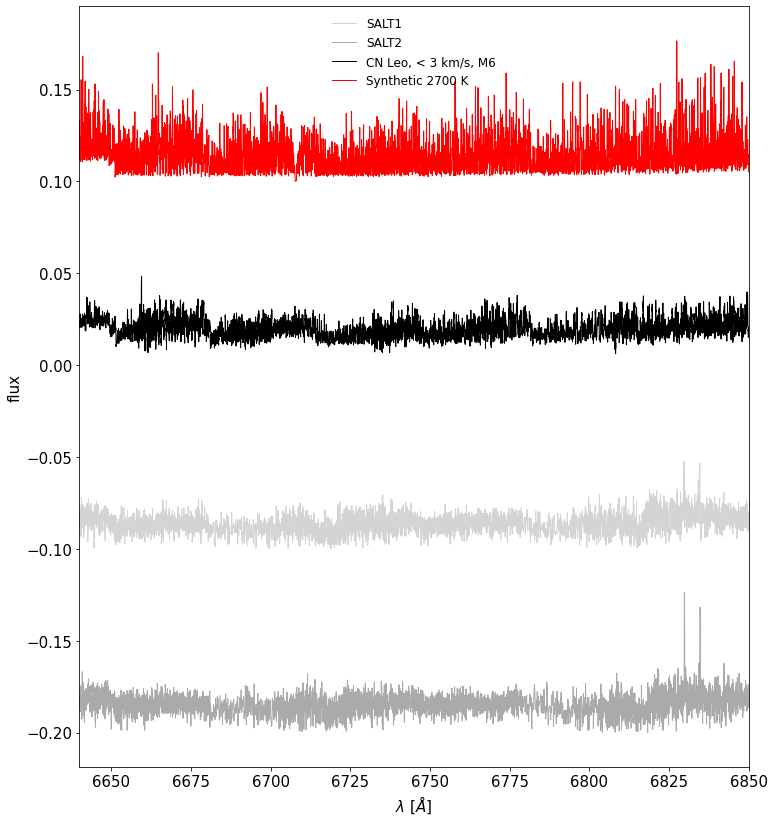

In [17]:
plt.figure(figsize=(12,14))

wavmin, wavmax =6640,6850#6556, 6570.5#7935, 7960#8160, 8200#6556, 6570.5#7940, 7960#,6708, 6728,#7930, 7965#7670, 7730#6556, 6570.5

# Show the SALT spectra
for sp, l in [(sp1,"1"), (sp2,"2") ]:#(settl7, "4")]:#, 
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    plt.plot(wav,mflux*100-float(l)/10,linewidth=1,alpha=float(l)/3, c="grey", label=f"SALT{l}")

# Show CN Leo
sp44 = cnleo[(cnleo.lambd>wavmin) & (cnleo.lambd<wavmax)]
plt.plot(sp44.lambd, sp44.flux*2, 
              c="k", linewidth=1, label="CN Leo, < 3 km/s, M6")

sp44 = settl7[(settl7.lambd>wavmin) & (settl7.lambd<wavmax)]
plt.plot(sp44.lambd, sp44.flux/1e6 +.1, 
              c="r", linewidth=1, label="Synthetic 2700 K")

# Chow the other Carmenes spectrum
# sp44 = carm[(carm.lambd>wavmin) & (carm.lambd<wavmax)]
# plt.plot(sp44.lambd, sp44.flux/sp44.flux.max()-1, 
#               c="orange", linewidth=1, label="CARMENES <2 km/s, M8, 2MUCD12171")

## Optionally, come back here to overplot broadened spectra
# for col in specs:
#     plt.plot(specs.index, specs[col])

# # Plot line position if desired
#plt.axvline(7948)


# Layout
plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
plt.xlabel(r"$\lambda$ [$\AA$]", fontsize=15)
plt.ylabel(r"flux", fontsize=15)
#plt.ylim(-1.5,4.3)
plt.legend(fontsize=12, frameon=False)


#plt.savefig("../plots/vsini/narrow_Rb_line.png", dpi=300)

413

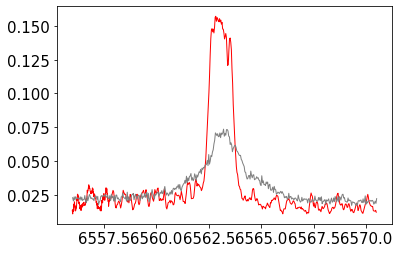

In [34]:
plt.plot(sp44.lambd, sp44.flux, 
              c="r", linewidth=1, label="CN Leo, < 3 km/s, M6")
wav = sp3.loc[(sp3.lambd>wavmin) & (sp3.lambd<wavmax),"lambd"].values
mflux = sp3.loc[(sp3.lambd>wavmin) & (sp3.lambd<wavmax),"flux"].values
plt.plot(wav,mflux*30,linewidth=1, c="grey", label="SALT3")
len(mflux)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [19]:
# Use CN Leo as a model spectrum
model=cnleo
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 
mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values
mflux = mflux
wav.shape

(577,)

In [215]:
# Choose vsini grid
vsinis = np.array(list(range(2,15,1)))# + list(range(30,110)))
vsinis

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [216]:
# Create a grid of broadened spectra
specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)



100%|██████████| 504/504 [00:01<00:00, 276.46it/s]

100%|██████████| 504/504 [00:00<00:00, 707.64it/s]

100%|██████████| 504/504 [00:00<00:00, 720.09it/s]

100%|██████████| 504/504 [00:00<00:00, 740.21it/s]

100%|██████████| 504/504 [00:00<00:00, 748.57it/s]

100%|██████████| 504/504 [00:00<00:00, 658.20it/s]

100%|██████████| 504/504 [00:00<00:00, 745.65it/s]

100%|██████████| 504/504 [00:00<00:00, 746.91it/s]

100%|██████████| 504/504 [00:00<00:00, 655.44it/s]

100%|██████████| 504/504 [00:00<00:00, 689.89it/s]

100%|██████████| 504/504 [00:00<00:00, 676.09it/s]

100%|██████████| 504/504 [00:00<00:00, 688.04it/s]

100%|██████████| 504/504 [00:00<00:00, 696.73it/s]


In [21]:
# Save and/or read grid of broadened spectra
#specs.to_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv",index=False)
specs = pd.read_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv")
specs = specs.set_index("wav")
specs.head()

,5,10,15,20,25,30,31,32,33,34,...,100,101,102,103,104,105,106,107,108,109
wav,,,,,,,,,,,,,,,,,,,,,
6556.008221,0.019061,0.018112,0.017207,0.017392,0.017843,0.018398,0.018519,0.018634,0.018762,0.018890,...,0.020324,0.020317,0.020312,0.020305,0.020299,0.020293,0.020287,0.020282,0.020279,0.020276
6556.009935,0.019121,0.018127,0.017217,0.017389,0.017848,0.018410,0.018528,0.018643,0.018770,0.018897,...,0.020325,0.020319,0.020313,0.020307,0.020300,0.020295,0.020289,0.020284,0.020280,0.020277
6556.028668,0.019799,0.018256,0.017355,0.017367,0.017946,0.018537,0.018645,0.018759,0.018872,0.018990,...,0.020338,0.020333,0.020328,0.020323,0.020317,0.020311,0.020305,0.020300,0.020295,0.020291
6556.040427,0.020181,0.018330,0.017444,0.017375,0.018009,0.018621,0.018725,0.018826,0.018937,0.019059,...,0.020345,0.020342,0.020338,0.020333,0.020327,0.020322,0.020317,0.020310,0.020304,0.020299
6556.049111,0.020412,0.018386,0.017509,0.017383,0.018064,0.018685,0.018788,0.018891,0.018994,0.019112,...,0.020351,0.020348,0.020345,0.020340,0.020336,0.020330,0.020324,0.020318,0.020312,0.020306


(568, 85)

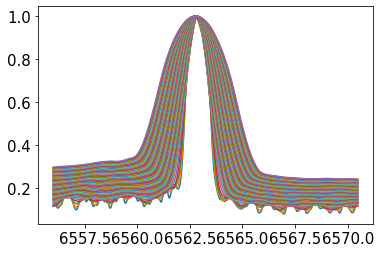

In [22]:
for row in specs:
    plt.plot(specs.index, specs[row]/specs[row].max())
specs.shape

In [47]:
sp = pd.DataFrame(sp3)
# Optionally mask a region in the SALT spectrum
# sp[((sp["lambd"]>7949) & (sp["lambd"]<7950))].flux = np.nan
# sp[(sp["lambd"]<7944)].flux = np.nan
# plt.plot(sp.lambd, sp.flux + .002, c="k")
# g = Gaussian1DKernel(stddev=1)
# sp['flux'] = convolve(sp.flux, g)
# plt.plot(sp.lambd, sp.flux)
# plt.xlim(wavmin, wavmax)
# plt.ylim(0.003,0.0091)
len(wav)
wav = specs.index.values

In [33]:
specs.shape

(568, 85)

In [41]:
vsinis = specs.columns.astype(float).values
def squared_diff(x):
    offset, amplitude, offy, vsini = x
    modelflux = specs[str(int(vsinis[np.argmin((vsini-vsinis)**2)]))]
    mflux = modelflux / np.max(modelflux)
    
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values + offset
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = amplitude * sfluxinterp / np.max(sfluxinterp) +  offy
    
    return ((mflux-sfluxinterp)**2).sum()

In [42]:
res = minimize(squared_diff, [(.1, .5, .1, 5.)], method='Powell', tol=1e-2)

In [43]:
res.x
# CN Leo 41,45,58.326
# V129 52,48,45

array([-0.27417634,  1.0045664 , -0.19822634, 23.70870106])

In [96]:
offset, amplitude, offy, vsini = res.x
offset

-0.2741763370832155

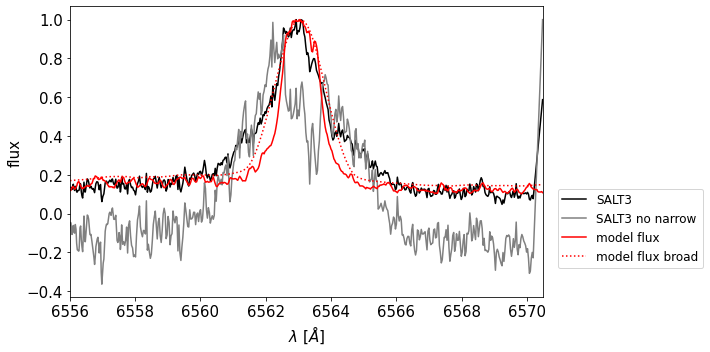

In [149]:
modelflux2 = broaden.rotational_convolution(wav, model.lambd, model.flux, 1, epsilon=.8)
modelflux1 = broaden.rotational_convolution(wav, model.lambd, model.flux, 50, epsilon=.8)

modelflux1 *= 1
mflux = (modelflux1 + modelflux2) / np.max(modelflux1 + modelflux2)
sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values + offset 
f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
sfluxinterp = f(wav)
sfluxinterp = amplitude * sfluxinterp / np.max(sfluxinterp) + offy

modelflux2 = modelflux2/np.max(modelflux2)
modelflux2 *= .5
sfluxinterpsub = amplitude * (sfluxinterp-modelflux2) / np.max(sfluxinterp-modelflux2) + offy
plt.figure(figsize=(10,5))
# for spec in specs:
#     if float(spec) <8:
#         modelflux = specs[spec]
#         mflux = modelflux / np.max(modelflux)
#         plt.plot(wav, mflux, alpha=float(spec)/100, 
#                  c="grey", linestyle="dashed", label=f"{spec} km/s")
        #plt.plot(wav, mflux - sfluxinterp-.2)
plt.plot(wav, sfluxinterp/np.max(sfluxinterp), c="k", label="SALT3")    
plt.plot(wav, sfluxinterpsub/np.max(sfluxinterpsub), c="grey", label="SALT3 no narrow")    
plt.plot(wav, mflux, c="r", label="model flux")  

modelflux1 = modelflux1/np.max(modelflux1)
plt.plot(wav, modelflux1, c="r",linestyle="dotted", label="model flux broad")  

#lr = lorentz(wav,6562.8,2.) +.18
#plt.plot(wav,lr/np.max(lr),label="Lorentz profile")
plt.xlabel(r"$\lambda$ [$\AA$]", fontsize=15)
plt.ylabel(r"flux", fontsize=15)
#plt.ylim(0,1.8)
plt.legend(loc=(1.03,.1), fontsize=12)
plt.xlim(wavmin, wavmax)
plt.tight_layout()
#plt.savefig("../plots/vsini/.png", dpi=300)

41.38 km /s

In [45]:
# convert wavelength to difference in velocity
l0 = wav[int(len(wav)/2)]
v = ((wav-l0)/wav * c).to("km/s")

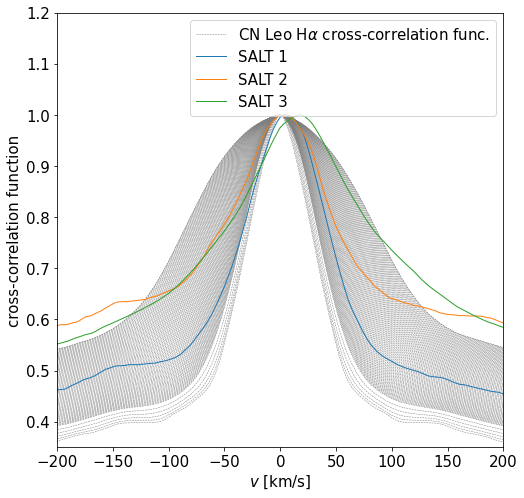

In [46]:
corrf = pd.DataFrame({"v":v})
plt.figure(figsize=(8,8))

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    if vsini>0:
        corr = correlate(specs[broad_spectrum],mflux, mode="same")
        me = np.max(corr)
        corrf[vsini] = corr/me
        plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed")#,label=f"{vsini} km/s")
plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed",label=r"CN Leo H$\alpha$ cross-correlation func.")
# corr = correlate(mflux,mflux, mode="same")
# me = np.max(corr)
# plt.plot(v,corr/me, c="grey", linewidth=0.5,label=f"0 km/s")
for sp, num in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:#,sp4]:
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = sfluxinterp / np.max(sfluxinterp)
    
#     corr = correlate(mflux,sfluxinterp, mode="same")
#     me = np.max(corr)
#     corrf["salt"] = corr/me
#     print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
#     plt.plot(v-45*u.km/u.s,corr/me, label=f"SALT", c="r", linewidth=1)
    
    corr = correlate(sfluxinterp,mflux, mode="same")
    me = np.max(corr)
    corrf["salt" + num] = corr/me
#    print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
    plt.plot(v,corr/me, label=f"SALT {num}", linewidth=1)
w = 200
plt.xlim(-w,w)
plt.ylim(0.35,1.2)
plt.xlabel(r"$v$ [km/s]", fontsize=15)
plt.ylabel("cross-correlation function", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig("../plots/vsini/CNleo_Halpha_cross_corr.png", dpi=300)

In [256]:
#corrf = corrf[(corrf.v>-1180) & (corrf.v<1180)]
corrf = corrf.set_index("v")

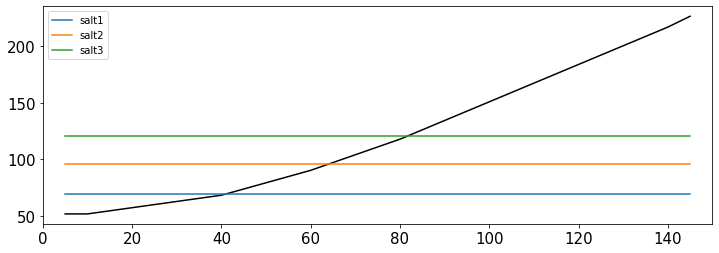

In [259]:
thresh=0.8
plt.figure(figsize=(12,4))
FWHM = corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]]-x.index[np.where(x>thresh)[0][0]], axis=0)
plt.plot(FWHM.index[:-3],FWHM.values[:-3], c="k")
for i in [-3,-2,-1]:
    plt.plot([FWHM.index[0],FWHM.index[-4]],[FWHM.values[i]]*2, label=FWHM.index[i])
plt.xlim(0,150)
plt.legend()

Rough first estimates:  

- 45 km/s, 81 km/s, 103 km/s (thresh 0.7)
- 47 km/s, 115 km/s, 118 km/s (thresh 0.65)

In [258]:
FWHM

5         79.469945
10        82.210525
15        84.951128
20        87.691756
25        90.432410
30        95.913794
35       101.395278
40       106.876845
45       112.358479
50       120.581017
55       128.803605
60       137.026186
65       147.989510
70       157.572300
75       168.534295
80       179.495762
85       190.456561
90       202.799502
95       213.759602
100      227.459128
105      238.418471
110      250.763582
115      261.186221
120      270.719109
125      279.376365
130      288.908375
135      298.437465
140      306.555908
145      316.078153
salt1    115.142210
salt2    263.715827
salt3    269.604360
dtype: float64